In [32]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
train = pd.read_csv("bitcoin_price_Training - bitcoin_price.2013Apr-2017Aug.csv.csv")
test = pd.read_csv("bitcoin_price_1week_Test - bitcoin_price_Aug2017_1week.csv")

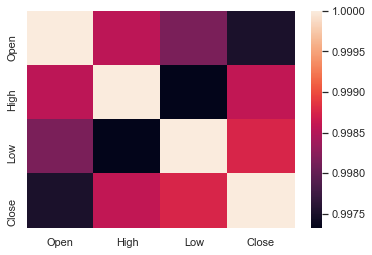

In [34]:
sns.heatmap(train.corr())

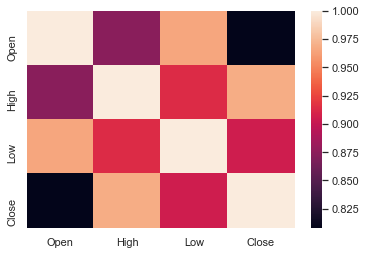

In [35]:
sns.heatmap(test.corr())

In [36]:
train = train[::-1]
test = test[::-1]

In [37]:
train.head()

,Date,Open,High,Low,Close,Volume,Market Cap
1555,"Apr 28, 2013",135.30,135.98,132.10,134.21,-,"1,500,520,000"
1554,"Apr 29, 2013",134.44,147.49,134.00,144.54,-,"1,491,160,000"
1553,"Apr 30, 2013",144.00,146.93,134.05,139.00,-,"1,597,780,000"
1552,"May 01, 2013",139.00,139.89,107.72,116.99,-,"1,542,820,000"
1551,"May 02, 2013",116.38,125.60,92.28,105.21,-,"1,292,190,000"


In [38]:
train = train['Close'].values.astype('float32')
test = test['Close'].values.astype('float32')

In [39]:
from sklearn.preprocessing import StandardScaler

In [40]:
# reshape data to scale the point
train = train.reshape(-1, 1)
test = test.reshape(-1, 1)

scaler = StandardScaler()
train_n = scaler.fit_transform(train)
test_n = scaler.transform(test)

In [41]:
print(train_n.shape)
print(test_n.shape)

(1556, 1)
(7, 1)


In [42]:
def generator(data, lookback, delay, min_index, max_index, 
              shuffle=False, batch_size=128, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
                
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay]
        yield samples, targets

In [43]:
lookback = 24
step = 1
delay = 7
batch_size = 128
train_gen = generator(train_n, lookback=lookback, delay=delay,
    min_index=0, max_index=1000, shuffle=True, step=step,
batch_size=batch_size)
val_gen = generator(train_n, lookback=lookback, delay=delay,
    min_index=1001, max_index=None, step=step, batch_size=batch_size)
test_gen = generator(test_n, lookback=lookback, delay=delay,
    min_index=0, max_index=None, step=step, batch_size=batch_size)
# This is how many steps to draw from `val_gen` in order to see the whole validation set:
val_steps = (len(train_n) - 1001 - lookback) // batch_size
# This is how many steps to draw from `test_gen` in order to see the whole test set:
test_steps = (len(test_n) - lookback) // batch_size

In [44]:
# reproducibility (make sure each time training is occurred, the result will be the same)
np.random.seed(7)

In [45]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [46]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, train_n.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 32)                3264      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
_________________________________________________________________


In [47]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 6s 11ms/step - loss: 0.1593 - val_loss: 1.2167
Epoch 2/40
500/500 [==============================] - 5s 10ms/step - loss: 0.1501 - val_loss: 1.1213
Epoch 3/40
500/500 [==============================] - 7s 15ms/step - loss: 0.1480 - val_loss: 1.1257
Epoch 4/40
500/500 [==============================] - 8s 16ms/step - loss: 0.1472 - val_loss: 1.1133
Epoch 5/40
500/500 [==============================] - 8s 16ms/step - loss: 0.1462 - val_loss: 1.1113
Epoch 6/40
500/500 [==============================] - 8s 16ms/step - loss: 0.1468 - val_loss: 1.1080
Epoch 7/40
500/500 [==============================] - 8s 16ms/step - loss: 0.1450 - val_loss: 1.0661
Epoch 8/40
500/500 [==============================] - 8s 16ms/step - loss: 0.1426 - val_loss: 1.0217
Epoch 9/40
500/500 [==============================] - 8s 16ms/step - loss: 0.1406 - val_loss: 1.0461
Epoch 10/40
500/500 [==============================] - 8s 16ms/step - loss: 0.1388 - val_lo

<Figure size 432x288 with 0 Axes>

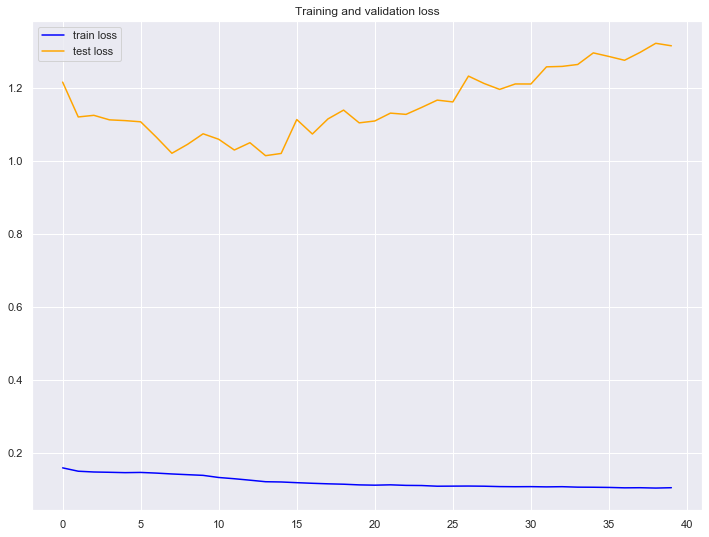

In [48]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.subplots(figsize=(12,9))
plt.plot(epochs, loss, 'blue', label='train loss')
plt.plot(epochs, val_loss, 'orange', label='test loss')
plt.title('Training and validation loss')
plt.legend()

In [49]:
train_re = train_n.reshape(-1,1,1)
pred = model.predict(train_re)

In [50]:
pred = scaler.inverse_transform(pred)

Text(0.5, 1.0, 'Prediction on training data')

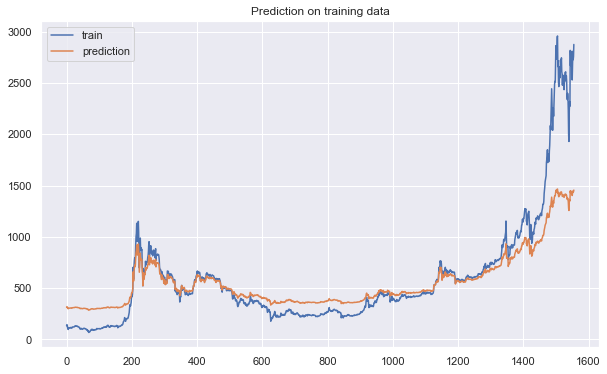

In [51]:
plt.subplots(figsize=(10,6))
plt.plot(range(len(train_re)), train, label='train')
plt.plot(range(len(train_re)), pred, label='prediction')
plt.legend()
plt.title("Prediction on training data")